<a href="https://colab.research.google.com/github/DataSayant1st/MachineLearning_and_AI/blob/main/Ensemble_Methods_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Titanic Passenger segmentation task using Ensemble methods


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats
import sklearn as sk
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import svm
import xgboost as xgb
import lightgbm as lgb
#from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

sns.set(style='white', context='notebook', palette='deep')

In [ ]:
test = pd.read_csv('/content/test.csv')
train = pd.read_csv('/content/train.csv')
combine = pd.concat([train.drop('Survived',1),test])


a bit of some overview

In [ ]:
surv = train[train['Survived']==1]
nosurv = train[train['Survived']==0]
surv_col = "blue"
nosurv_col = "red"

print("Survived: %i (%.1f percent), Not Survived: %i (%.1f percent), Total: %i"\
      %(len(surv), 1.*len(surv)/len(train)*100.0,\
        len(nosurv), 1.*len(nosurv)/len(train)*100.0, len(train)))

Survived: 342 (38.4 percent), Not Survived: 549 (61.6 percent), Total: 891


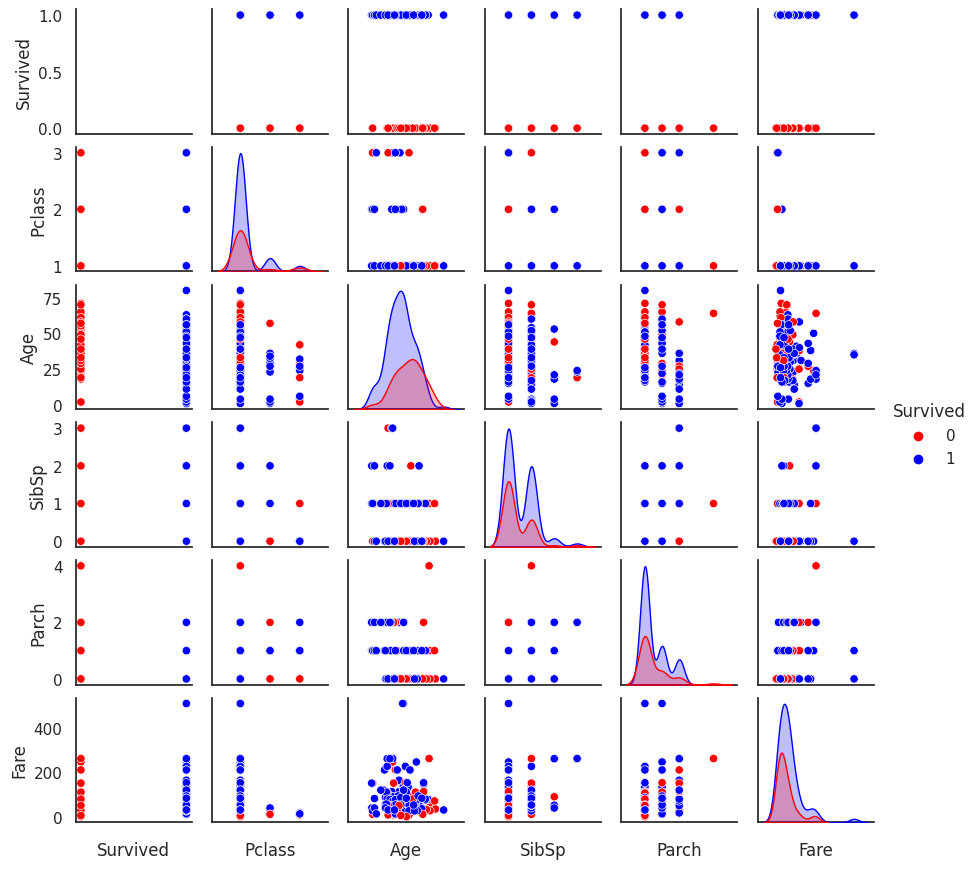

In [ ]:
cols = ['Survived','Pclass','Age','SibSp','Parch','Fare']
g = sns.pairplot(data=train.dropna(), vars=cols, size=1.5,
                 hue='Survived', palette=[nosurv_col,surv_col])
g.set(xticklabels=[])

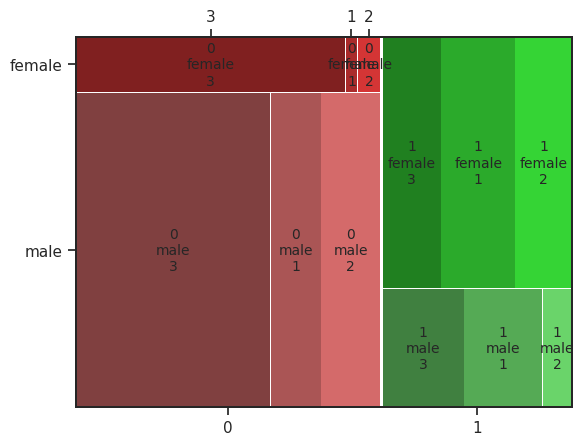

In [ ]:
dummy = mosaic(train,["Survived","Sex","Pclass"])

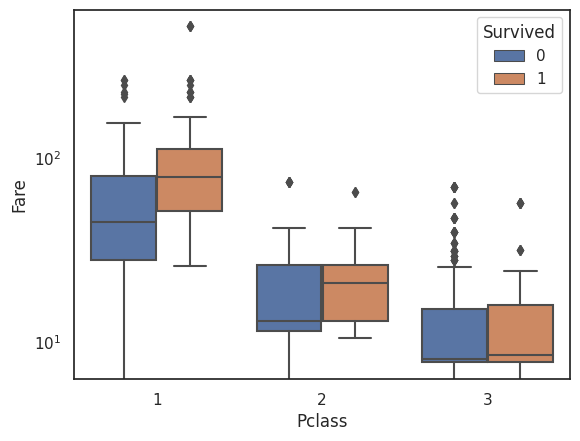

In [ ]:
ax = sns.boxplot(x="Pclass", y="Fare", hue="Survived", data=train);
ax.set_yscale('log')

Filling in missing values

In [ ]:
print(train[train['Embarked'].isnull()])

     PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   female  38.0      0      0  113572  80.0   B28      NaN  
829  female  62.0      0      0  113572  80.0   B28      NaN  


In [ ]:
combine.where((combine['Embarked'] !='Q') & (combine['Pclass'] < 1.5) & \
    (combine['Sex'] == "female")).groupby(['Embarked','Pclass','Sex','Parch','SibSp']).size()

Embarked  Pclass  Sex     Parch  SibSp
C         1.0     female  0.0    0.0      30
                                 1.0      20
                          1.0    0.0      10
                                 1.0       6
                          2.0    0.0       2
                                 2.0       2
                          3.0    1.0       1
S         1.0     female  0.0    0.0      20
                                 1.0      20
                                 2.0       3
                          1.0    0.0       7
                                 1.0       6
                          2.0    0.0       4
                                 1.0       5
                                 3.0       3
                          4.0    1.0       1
dtype: int64

In [ ]:
train['Embarked'].iloc[61] = "C"
train['Embarked'].iloc[829] = "C"

In [ ]:
print(test[test['Fare'].isnull()])

     PassengerId  Pclass                Name   Sex   Age  SibSp  Parch Ticket  \
152         1044       3  Storey, Mr. Thomas  male  60.5      0      0   3701   

     Fare Cabin Embarked  
152   NaN   NaN        S  


In [ ]:
test['Fare'].iloc[152] = combine['Fare'][combine['Pclass'] == 3].dropna().median()
print(test['Fare'].iloc[152])

8.05


features engineering

In [ ]:
combine = pd.concat([train.drop('Survived',1),test])
survived = train['Survived']

combine['Child'] = combine['Age']<=10
combine['Cabin_known'] = combine['Cabin'].isnull() == False
combine['Age_known'] = combine['Age'].isnull() == False
combine['Family'] = combine['SibSp'] + combine['Parch']
combine['Alone']  = (combine['SibSp'] + combine['Parch']) == 0
combine['Large_Family'] = (combine['SibSp']>2) | (combine['Parch']>3)
combine['Deck'] = combine['Cabin'].str[0]
combine['Deck'] = combine['Deck'].fillna(value='U')
combine['Ttype'] = combine['Ticket'].str[0]
combine['Title'] = combine['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
combine['Fare_cat'] = pd.DataFrame(np.floor(np.log10(combine['Fare'] + 1))).astype('int')
combine['Bad_ticket'] = combine['Ttype'].isin(['3','4','5','6','7','8','A','L','W'])
combine['Young'] = (combine['Age']<=30) | (combine['Title'].isin(['Master','Miss','Mlle']))
combine['Shared_ticket'] = np.where(combine.groupby('Ticket')['Name'].transform('count') > 1, 1, 0)
combine['Ticket_group'] = combine.groupby('Ticket')['Name'].transform('count')
combine['Fare_eff'] = combine['Fare']/combine['Ticket_group']
combine['Fare_eff_cat'] = np.where(combine['Fare_eff']>16.0, 2, 1)
combine['Fare_eff_cat'] = np.where(combine['Fare_eff']<8.5,0,combine['Fare_eff_cat'])
test = combine.iloc[len(train):]
train = combine.iloc[:len(train)]
train['Survived'] = survived

surv = train[train['Survived']==1]
nosurv = train[train['Survived']==0]

title

In [ ]:
print(combine['Age'].groupby(combine['Title']).count())
print(combine['Age'].groupby(combine['Title']).mean())

print("There are %i unique titles in total."%(len(combine['Title'].unique())))

Title
Capt              1
Col               4
Don               1
Dona              1
Dr                7
Jonkheer          1
Lady              1
Major             2
Master           53
Miss            210
Mlle              2
Mme               1
Mr              581
Mrs             170
Ms                1
Rev               8
Sir               1
the Countess      1
Name: Age, dtype: int64
Title
Capt            70.000000
Col             54.000000
Don             40.000000
Dona            39.000000
Dr              43.571429
Jonkheer        38.000000
Lady            48.000000
Major           48.500000
Master           5.482642
Miss            21.774238
Mlle            24.000000
Mme             24.000000
Mr              32.252151
Mrs             36.994118
Ms              28.000000
Rev             41.250000
Sir             49.000000
the Countess    33.000000
Name: Age, dtype: float64
There are 18 unique titles in total.


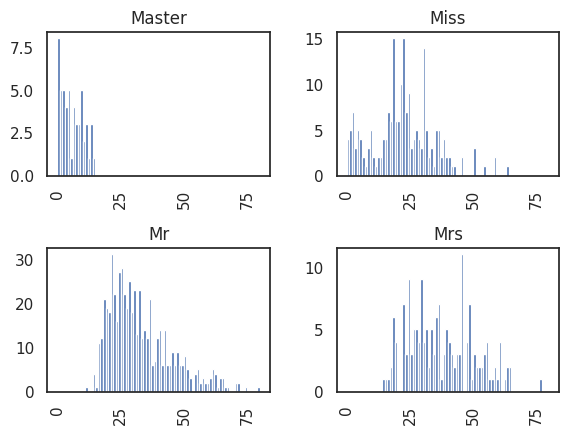

In [ ]:
dummy = combine[combine['Title'].isin(['Mr','Miss','Mrs','Master'])]
foo = dummy['Age'].hist(by=dummy['Title'], bins=np.arange(0,81,1))

Preparing for modelling


In [ ]:
combine = pd.concat([train.drop('Survived',1),test])
survived = train['Survived']

combine["Sex"] = combine["Sex"].astype("category")
combine["Sex"].cat.categories = [0,1]
combine["Sex"] = combine["Sex"].astype("int")
combine["Embarked"] = combine["Embarked"].astype("category")
combine["Embarked"].cat.categories = [0,1,2]
combine["Embarked"] = combine["Embarked"].astype("int")
combine["Deck"] = combine["Deck"].astype("category")
combine["Deck"].cat.categories = [0,1,2,3,4,5,6,7,8]
combine["Deck"] = combine["Deck"].astype("int")

test = combine.iloc[len(train):]
train = combine.iloc[:len(train)]
train['Survived'] = survived

train.loc[:,["Sex","Embarked"]].head()

,Sex,Embarked
0,1,2
1,0,0
2,0,2
3,0,2
4,1,2


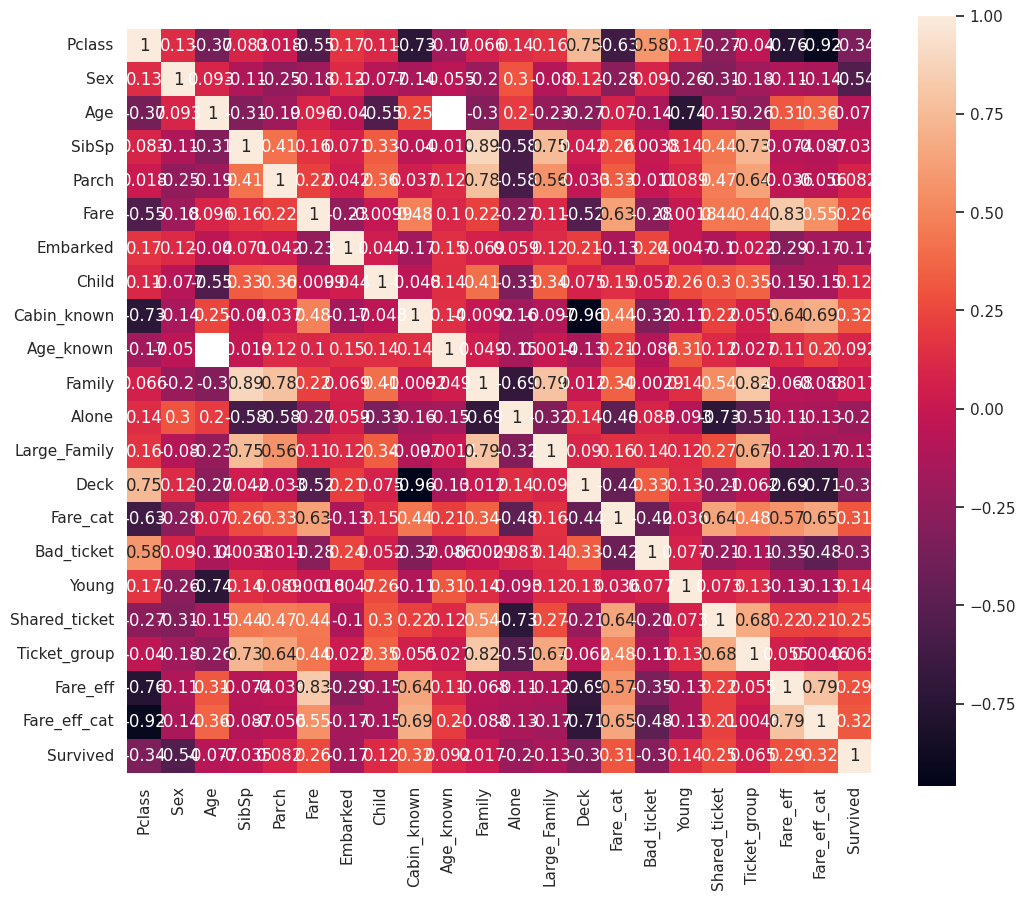

In [ ]:
ax = plt.subplots( figsize =( 12 , 10 ) )
foo = sns.heatmap(train.drop('PassengerId',axis=1).corr(), vmax=1.0, square=True, annot=True)

modelling

1. Splitting the train sample into two sub-samples: training and testing

In [ ]:
training, testing = train_test_split(train, test_size=0.2, random_state=0)
print("Total sample size = %i; training sample size = %i, testing sample size = %i"\
     %(train.shape[0],training.shape[0],testing.shape[0]))

Total sample size = 891; training sample size = 712, testing sample size = 179


Test and select the model features

In [ ]:
cols = ['Sex','Pclass','Cabin_known','Large_Family','Parch',
        'SibSp','Young','Alone','Shared_ticket','Child']
tcols = np.append(['Survived'],cols)

df = training.loc[:,tcols].dropna()
X = df.loc[:,cols]
y = np.ravel(df.loc[:,['Survived']])

In [ ]:
clf_log = LogisticRegression()
clf_log = clf_log.fit(X,y)
score_log = clf_log.score(X,y)
print(score_log)

0.8174157303370787


In [ ]:
pd.DataFrame(list(zip(X.columns, np.transpose(clf_log.coef_))))

,0,1
0,Sex,[-2.507094016151233]
1,Pclass,[-0.7134919404560917]
2,Cabin_known,[0.4332184617915548]
3,Large_Family,[-1.2066917803867618]
4,Parch,[-0.080356848088027]
5,SibSp,[-0.33056997980707375]
6,Young,[0.420624447926907]
7,Alone,[-0.3230280074577887]
8,Shared_ticket,[-0.00763498354196044]
9,Child,[1.4848921724317241]


In [ ]:
cols = ['Sex','Pclass','Cabin_known','Large_Family','Shared_ticket','Young','Alone','Child']
tcols = np.append(['Survived'],cols)

df = training.loc[:,tcols].dropna()
X = df.loc[:,cols]
y = np.ravel(df.loc[:,['Survived']])

df_test = testing.loc[:,tcols].dropna()
X_test = df_test.loc[:,cols]
y_test = np.ravel(df_test.loc[:,['Survived']])

Logistic Regression again, this time with only the selected columns

In [ ]:
clf_log = LogisticRegression()
clf_log = clf_log.fit(X,y)
score_log = cross_val_score(clf_log, X, y, cv=5).mean()
print(score_log)

0.8075839653304442


perceptron

In [ ]:
clf_pctr = Perceptron(
    class_weight='balanced'
    )
clf_pctr = clf_pctr.fit(X,y)
score_pctr = cross_val_score(clf_pctr, X, y, cv=5).mean()
print(score_pctr)

0.6073672806067172


KNN

In [ ]:
clf_knn = KNeighborsClassifier(
    n_neighbors=10,
    weights='distance'
    )
clf_knn = clf_knn.fit(X,y)
score_knn = cross_val_score(clf_knn, X, y, cv=5).mean()
print(score_knn)

0.8076036639416921


Support Vector Machine

In [ ]:
clf_svm = svm.SVC(
    class_weight='balanced'
    )
clf_svm.fit(X, y)
score_svm = cross_val_score(clf_svm, X, y, cv=5).mean()
print(score_svm)

0.8216487737614498


Naive Bayes

In [ ]:
clf_bay = GaussianNB()
clf_bay.fit(X,y)
score_bay = cross_val_score(clf_bay, X, y, cv=5).mean()
print(score_bay)

0.7879936964444008


**Bagging**

In [ ]:
bagging = BaggingClassifier(
    KNeighborsClassifier(
        n_neighbors=2,
        weights='distance'
        ),
    oob_score=True,
    max_samples=0.5,
    max_features=1.0
    )
clf_bag = bagging.fit(X,y)
score_bag = clf_bag.oob_score_
print(score_bag)

0.8033707865168539


Bagging is a general ensemble method. This means it's a way to average over a (large) number of individual classifiers to improve their accuracy by reducing the variance (= noise). The estimator (above it's a KNN) is used multiple times on subsets of the training sample and then it uses the average vote.

Bagging for a decision tree classifier should be the same as using a Random Forest (see below).

Strictly speaking, bagging is only the correct term if the sub samples are drawn with replacement (i.e. put back into the bag, I suppose). Otherwise it's called Pasting.

If sub-samples are used then the remaining samples (the ones not in the bag we're drawing the data from) can be used in out-of-bag (oob) estimates (-> oob_score=True). This is a kind of inbuilt cross-validation step, since the accuracy (score) of the classifier is estimated on data it wasn't trained on.

Decision Tree

In [ ]:
clf_tree = tree.DecisionTreeClassifier(
    #max_depth=3,\
    class_weight="balanced",\
    min_weight_fraction_leaf=0.01\
    )
clf_tree = clf_tree.fit(X,y)
score_tree = cross_val_score(clf_tree, X, y, cv=5).mean()
print(score_tree)

0.8118290160543682


Decision Tree: One of the classifiers that's easiest to visualise. Each tree is a series of if-then-else decisions. Example: if sex == male then go left else go right. Here, left and right defines a split at a so called node - the decision itself. The first split can be followed up by additional ones to narrow down the decision criteria (based on the subset defined by each previous split).

One visualisation of this process is a tree trunk branching off into successively smaller structures. Hence: decision tree. Consequently, the result of the final splits are called leaf notes - on a tree, it doesn't get smaller than leafs.

Advantages of decision trees are that they can deal with both numerical and categorical data, are able to handle multi-output problems, and are easy to follow and interpret.

Disadvantages include:

Problem: A tendency to overfitting. Solution: pruning, setting maximum depth, or PCA beforehand to find the right number of features. Visualising the tree helps to understand how well it is fitting the data.

Problem: Unstable to small variations in the data. Solution: ensembles.

Problem: Creating biased trees if some classes dominate. Solution: balance the data set by either sampling the same number of samples from each class or by adjusting the sample_weight parameter to normalise the sum of the class weights to the same value. Following that, parameter min_weight_fraction_leaf is less biased towards dominating classes.

Problem: Being just not easy to fit to certain concepts that don't lend themselves to clear yes-or-no decisions. Solution: Use a different classifier.

Random Forest

In [ ]:
clf_rf = RandomForestClassifier(
    n_estimators=1000, \
    max_depth=None, \
    min_samples_split=10 \
    #class_weight="balanced", \
    #min_weight_fraction_leaf=0.02 \
    )
clf_rf = clf_rf.fit(X,y)
score_rf = cross_val_score(clf_rf, X, y, cv=5).mean()
print(score_rf)

0.8230178272431793


Extremely Randomised Trees

In [ ]:
clf_ext = ExtraTreesClassifier(
    max_features='auto',
    bootstrap=True,
    oob_score=True,
    n_estimators=1000,
    max_depth=None,
    min_samples_split=10
    #class_weight="balanced",
    #min_weight_fraction_leaf=0.02
    )
clf_ext = clf_ext.fit(X,y)
score_ext = cross_val_score(clf_ext, X, y, cv=5).mean()
print(score_ext)

0.8230178272431793


Extremely Randomised Trees is an ensemble classifier similar to random forests. An additional randomness is introduced by selecting random thresholds for each feature and using the best-performing threshold.

Here we also use an "Out-of-bag score" (oob_score = True). This means that we grow our trees from a sub-sample of the training sample (using bootstrapping: boostrap = True) and estimate the accuracy based on those entries that were not picked (i.e. "left out of the bag"). This gives us a better impression how robust our results are towards generalisation, i.e. how well the classifier that was trained on a particular sample can be applied to new data.

Because this is ultimately our goal: to apply the classification method we "learn" from the training data to any data (in particular the one that is used to judge this competition). There is little use in having a classifier that replicates perfectly the training data by following every random noise feature in that data (called overfitting) but doesn't perform well with new data.

The principles of bootstrapping and the out-of-bag score can be applied to most classifiers and we already used them in the bagging classifier above. Here we just focus a bit on the underlying idea.

Gradient Boosting

In [ ]:
import warnings
warnings.filterwarnings("ignore")

clf_gb = GradientBoostingClassifier(
            #loss='exponential',
            n_estimators=1000,
            learning_rate=0.1,
            max_depth=3,
            subsample=0.5,
            random_state=0).fit(X, y)
clf_gb.fit(X,y)
score_gb = cross_val_score(clf_gb, X, y, cv=5).mean()
print(score_gb)

0.8117797695262485


Gradient boosting: This is what we call the step-by-step improvement of a weak classifier (like a tree with only 1 node) by successively applying this classifier to the residuals of the previous classifier's results.

For example: we fit a tree, determine its results (prediction: survived vs not survived), compute the residuals of this prediction vs the real survival numbers (all in the training data, of course), and then fit another tree to these residuals. This tree can now consider the full number of training samples for splitting a node at another feature, instead of having to deal with the decreased sample after the first original node (and the resulting impact of random fluctuations). This can be done again and again for n_estimator number of times.

The weak classifier itself does not necessarily have to be a tree, but a tree seems to be the favourite approach to use here. Another convention is to initialise this sequence of models with a single prediction value (like the mean of the training survival values).

Instead of reducing the residuals (and the corresponding squared errors) Gradient Boosting focusses on minimising the Loss Function by training the classifier on the gradient of this function. The Loss Function describes how much the prediction is improved when shifting the predicted values by a certain amount. The method of Gradient Decent uses this Loss Function to iteratively move into the direction of its greatest decent (i.e. most negative first derivative). The step sizes can vary from iteration to iteration.

An additional concept is Shrinkage. Here, the size of each step multiplied by a factor (0,1]. In the model parameters, this factor is called the learning_rate. Lower learning rates make for a slower decent which seems to be empirically more effective.
One more step is to provide a sampling of rows and features, like in the random forest discussed above, to increase the diversity in tree splits and thereby a larger amount of information for the method to work with.

The important parameters are:

n_estimators: number of boosting stages; more is better

learning_rate: smaller steps need more stages

max_depth: tune for best performance; depends on interaction of features

subsample: only train on a sub sample of the data set drawn without replacement. This is called Stochastic Gradient Decent